# Explore Students Performance in Exams
The [Students Performance in Exams](https://www.kaggle.com/spscientist/students-performance-in-exams) dataset is taken from Kaggle. It has students' demographic information as well as scores in various subjects.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from scipy.stats import zscore
from scipy import stats
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

## Load the data

In [2]:
# PostgreSQL credentials
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "studentsperformance"

# Read the data from the studentsperformance table
engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

scores = pd.read_sql_query("select * from studentsperformance", con=engine)

engine.dispose()

## Clean the data

### Descriptions

In [3]:
# First 5 rows
scores.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
# Descriptive stats
scores.describe(include="all")

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
count,1000,1000,1000,1000,1000,1000.00000,1000.000000,1000.000000
unique,2,5,6,2,2,NaN,NaN,NaN
top,female,group C,some college,standard,none,NaN,NaN,NaN
freq,518,319,226,645,642,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,66.08900,69.169000,68.054000
std,NaN,NaN,NaN,NaN,NaN,15.16308,14.600192,15.195657
min,NaN,NaN,NaN,NaN,NaN,0.00000,17.000000,10.000000
25%,NaN,NaN,NaN,NaN,NaN,57.00000,59.000000,57.750000
50%,NaN,NaN,NaN,NaN,NaN,66.00000,70.000000,69.000000
75%,NaN,NaN,NaN,NaN,NaN,77.00000,79.000000,79.000000


### Deal with missing values

In [5]:
# Check if there are any missing values
scores.isnull().values.any()

False

There are no missing values in this dataset! Let's go on to examine outliers.

### Deal with outliers

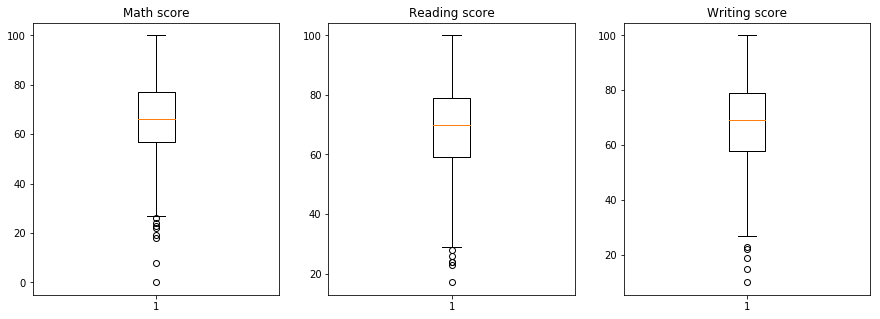

In [6]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.boxplot(scores["math score"])
plt.title("Math score")

plt.subplot(1, 3, 2)
plt.boxplot(scores["reading score"])
plt.title("Reading score")

plt.subplot(1, 3, 3)
plt.boxplot(scores["writing score"])
plt.title("Writing score")

plt.tight_layout
plt.show()

All three subjects have outliers on the lower end. We can winsorize low scores by replacing them with the 5th quantile.

In [7]:
# Winsorize all scores
scores["math_winsorized"] = winsorize(scores["math score"], limits=[0.05, 0])

scores["reading_winsorized"] = winsorize(scores["reading score"], limits=[0.05, 0])

scores["writing_winsorized"] = winsorize(scores["writing score"], limits=[0.05, 0])

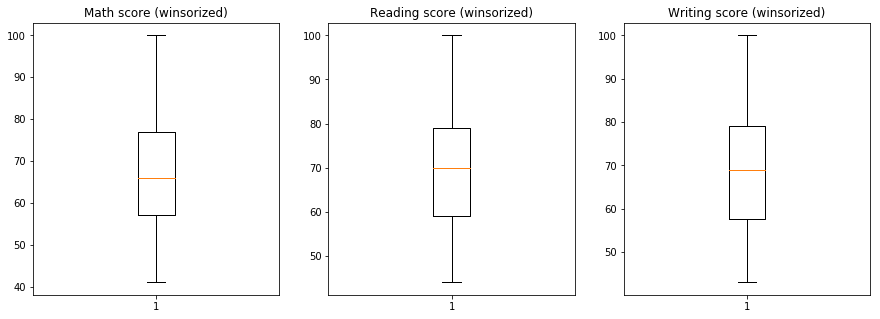

In [8]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.boxplot(scores["math_winsorized"])
plt.title("Math score (winsorized)")

plt.subplot(1, 3, 2)
plt.boxplot(scores["reading_winsorized"])
plt.title("Reading score (winsorized)")

plt.subplot(1, 3, 3)
plt.boxplot(scores["writing_winsorized"])
plt.title("Writing score (winsorized)")

plt.tight_layout
plt.show()

As can be seen, outliers are now eliminated.

## Questions

### 1. Are there any differences between the genders, ethnicities, and parental level of education with respect to their performances in exams?

#### Gender

In [9]:
# Create a new dataframe of gender and scores
gender = scores[
    ["gender", "math_winsorized", "reading_winsorized", "writing_winsorized"]
]

gender.loc[:, "id"] = gender.index.tolist()

/Users/apple/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/apple/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
# Reshape data from wide to long
gender_long = pd.melt(
    gender,
    id_vars=["id", "gender"],
    value_vars=["math_winsorized", "reading_winsorized", "writing_winsorized"],
    var_name="subject",
    value_name="scores",
)

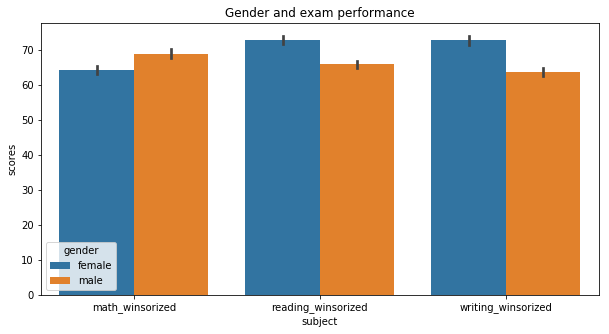

In [11]:
# Plot exam performance for each gender
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="subject", y="scores", hue="gender", data=gender_long)
plt.title("Gender and exam performance")
plt.show()

Compared to male students, female students seem to perform slightly better on reading and writing but worse on math. Results from two-way ANOVA suggest that there is indeed a significant interaction between gender and subject.

In [12]:
# In the Ordinary Least Squares (OLS) model
# C(gender):C(subject) represent interaction term
model = ols(
    "scores ~ C(gender) + C(subject) + C(gender):C(subject)", data=gender_long
).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(gender),10918.422782,1.0,58.325856,2.968276e-14
C(subject),4623.440667,2.0,12.349134,4.558683e-06
C(gender):C(subject),26916.520638,2.0,71.893584,3.188490e-31
Residual,560467.694580,2994.0,NaN,NaN


We can use independent samples $t$-test to further examine gender differences in each subject. 

In [13]:
# Create separate dataframes for each subject
math = gender_long.loc[gender_long["subject"] == "math_winsorized"]

reading = gender_long.loc[gender_long["subject"] == "reading_winsorized"]

writing = gender_long.loc[gender_long["subject"] == "writing_winsorized"]

# Male vs. female in math
t_math = stats.ttest_ind(
    math.loc[math["gender"] == "male", "scores"],
    math.loc[math["gender"] == "female", "scores"],
)

print(
    "Male students score significantly higher in math than female students, t = {}, p = {}.".format(
        round(t_math[0], 2), round(t_math[1], 2)
    )
)

# Male vs. female in reading
t_reading = stats.ttest_ind(
    reading.loc[reading["gender"] == "male", "scores"],
    reading.loc[reading["gender"] == "female", "scores"],
)

print(
    "Male students score significantly lower in reading than female students, t = {}, p = {}.".format(
        round(t_reading[0], 2), round(t_reading[1], 2)
    )
)

# Male vs. female in writing
t_writing = stats.ttest_ind(
    writing.loc[writing["gender"] == "male", "scores"],
    writing.loc[writing["gender"] == "female", "scores"],
)

print(
    "Male students score significantly lower in writing than female students, t = {}, p = {}.".format(
        round(t_writing[0], 2), round(t_writing[1], 2)
    )
)

Male students score significantly higher in math than female students, t = 5.16, p = 0.0.
Male students score significantly lower in reading than female students, t = -8.26, p = 0.0.
Male students score significantly lower in writing than female students, t = -10.48, p = 0.0.


Even when we use a conservative $\alpha$ level (e.g., .05/3), gender differences on all three subjects are still statistically significant.

#### Ethnicity

In [14]:
# Create a new dataframe of race/ethnicity and scores
ethnicity = scores[
    ["race/ethnicity", "math_winsorized", "reading_winsorized", "writing_winsorized"]
]

ethnicity.loc[:, "id"] = ethnicity.index.tolist()

In [15]:
# Reshape data from wide to long
ethnicity_long = pd.melt(
    ethnicity,
    id_vars=["id", "race/ethnicity"],
    value_vars=["math_winsorized", "reading_winsorized", "writing_winsorized"],
    var_name="subject",
    value_name="scores",
)

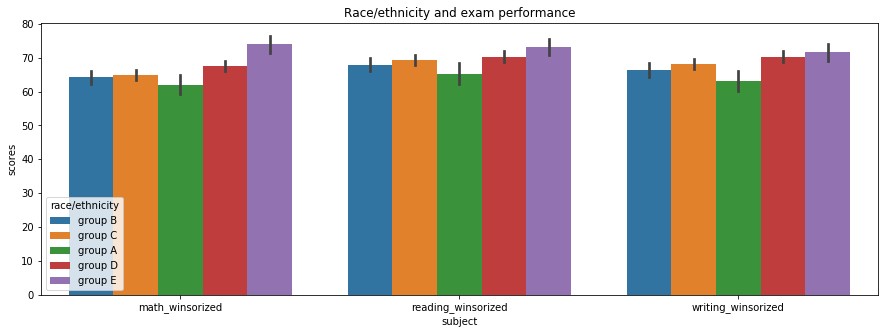

In [16]:
# Plot exam performance for each race/ethnicity
plt.figure(figsize=(15, 5))
ax = sns.barplot(x="subject", y="scores", hue="race/ethnicity", data=ethnicity_long)
plt.title("Race/ethnicity and exam performance")
plt.show()

Among all groups, group E seems to have the best performance on all subjects, which is followed by group D. By contrast, group A has the worse performance on all subjects than the other groups. Groups B and C have middling performance on these subjects.

#### Parental level of education

In [17]:
# Create a new dataframe of parental education and scores
parent_edu = scores[
    [
        "parental level of education",
        "math_winsorized",
        "reading_winsorized",
        "writing_winsorized",
    ]
]

parent_edu.loc[:, "id"] = parent_edu.index.tolist()

In [18]:
# Reshape data from wide to long
parent_edu_long = pd.melt(
    parent_edu,
    id_vars=["id", "parental level of education"],
    value_vars=["math_winsorized", "reading_winsorized", "writing_winsorized"],
    var_name="subject",
    value_name="scores",
)

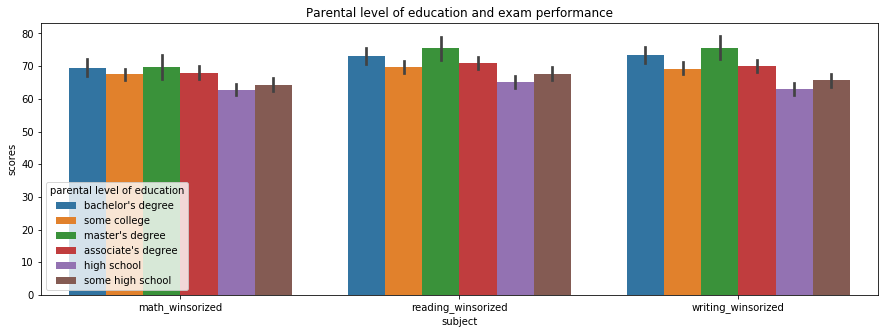

In [19]:
# Plot exam performance for each parental level of education
plt.figure(figsize=(15, 5))
ax = sns.barplot(
    x="subject", y="scores", hue="parental level of education", data=parent_edu_long
)
plt.title("Parental level of education and exam performance")
plt.show()

Generally, the higher the parental education level, the higher the average score, no matter what the subject is.

### 2. Are there any differences between the lunch types with respect to their performances in exams? If there are, how do you explain this?

In [20]:
# Create a new dataframe of lunch type and scores
lunch = scores[
    ["lunch", "math_winsorized", "reading_winsorized", "writing_winsorized",]
]

lunch.loc[:, "id"] = lunch.index.tolist()

In [21]:
# Reshape data from wide to long
lunch_long = pd.melt(
    lunch,
    id_vars=["id", "lunch"],
    value_vars=["math_winsorized", "reading_winsorized", "writing_winsorized"],
    var_name="subject",
    value_name="scores",
)

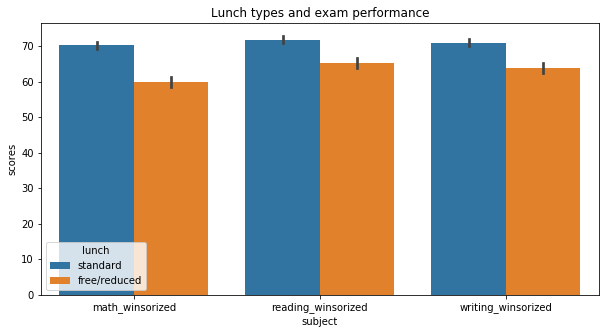

In [22]:
# Plot exam performance for lunch type
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="subject", y="scores", hue="lunch", data=lunch_long)
plt.title("Lunch types and exam performance")
plt.show()

Students who have standard lunch seem to score higher on all subjects compared to those who have free/reduced lunch.

In [33]:
# In the Ordinary Least Squares (OLS) model
# C(lunch):C(subject) represent interaction term
model = ols(
    "scores ~ C(lunch) + C(subject) + C(lunch):C(subject)", data=lunch_long
).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(lunch),43328.547146,1.0,234.533868,5.003586e-51
C(subject),4623.440667,2.0,12.513152,3.874305e-06
C(lunch):C(subject),1852.824253,2.0,5.014593,6.696216e-03
Residual,553121.266601,2994.0,NaN,NaN


The ANOVA results suggest that lunch types indeed have a significant impact on scores.

In [35]:
# Create separate dataframes for each subject
math = lunch_long.loc[lunch_long["subject"] == "math_winsorized"]

reading = lunch_long.loc[lunch_long["subject"] == "reading_winsorized"]

writing = lunch_long.loc[lunch_long["subject"] == "writing_winsorized"]

# Standard vs. free lunch in math
t_math = stats.ttest_ind(
    math.loc[math["lunch"] == "standard", "scores"],
    math.loc[math["lunch"] == "free/reduced", "scores"],
)

print(
    "Students who have standard lunch scored significantly higher in math, t = {}, p = {}.".format(
        round(t_math[0], 2), round(t_math[1], 2)
    )
)

# Standard vs. free lunch in reading
t_reading = stats.ttest_ind(
    reading.loc[reading["lunch"] == "standard", "scores"],
    reading.loc[reading["lunch"] == "free/reduced", "scores"],
)

print(
    "Students who have standard lunch scored significantly higher in reading, t = {}, p = {}.".format(
        round(t_reading[0], 2), round(t_reading[1], 2)
    )
)

# Standard vs. free lunch in writing
t_writing = stats.ttest_ind(
    writing.loc[writing["lunch"] == "standard", "scores"],
    writing.loc[writing["lunch"] == "free/reduced", "scores"],
)

print(
    "Students who have standard lunch scored significantly higher in writing, t = {}, p = {}.".format(
        round(t_writing[0], 2), round(t_writing[1], 2)
    )
)

Students who have standard lunch scored significantly higher in math, t = 11.61, p = 0.0.
Students who have standard lunch scored significantly higher in reading, t = 7.23, p = 0.0.
Students who have standard lunch scored significantly higher in writing, t = 7.76, p = 0.0.


Upon closer look, lunch types have significant effects on all subjects but most strongly on math. This is corroborated by the significant interaction between lunch type and subject we found earlier. One explanation as to why lunch types matter could be that nutrition plays a critical role in learning. However, it could also be that students who choose or are forced to have free/reduced lunch generally come from low-socioeconomic status (SES) households and lack educational resources like their wealthier peers do.

### 3. Does the test preparation course seem to have an effect on the exam performances?

In [24]:
# Create a new dataframe of test prep status and scores
prep = scores[
    [
        "test preparation course",
        "math_winsorized",
        "reading_winsorized",
        "writing_winsorized",
    ]
]

prep.loc[:, "id"] = prep.index.tolist()

In [25]:
# Reshape data from wide to long
prep_long = pd.melt(
    prep,
    id_vars=["id", "test preparation course"],
    value_vars=["math_winsorized", "reading_winsorized", "writing_winsorized"],
    var_name="subject",
    value_name="scores",
)

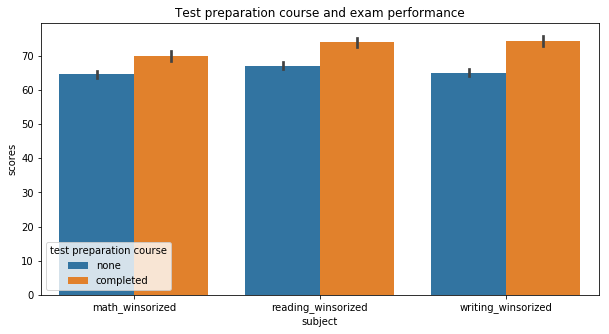

In [26]:
# Plot exam performance for test prep status
plt.figure(figsize=(10, 5))
ax = sns.barplot(x="subject", y="scores", hue="test preparation course", data=prep_long)
plt.title("Test preparation course and exam performance")
plt.show()

Those who have completed the test preparation course scored higher on all three subjects than those who didn't.

In [44]:
# Rename the column with spaces
prep_long.rename(columns={"test preparation course": "prep"}, inplace=True)

# In the Ordinary Least Squares (OLS) model
# C(prep):C(subject) represent interaction term
model = ols("scores ~ C(prep) + C(subject) + C(prep):C(subject)", data=prep_long).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(prep),35522.368601,1.0,189.662814,6.936078e-42
C(subject),4623.440667,2.0,12.342853,4.587169e-06
C(prep):C(subject),2027.377633,2.0,5.412338,4.504953e-03
Residual,560752.891766,2994.0,NaN,NaN


This observation is supported by the significant main effect of test prep status on scores.

In [47]:
# Create separate dataframes for each subject
math = prep_long.loc[prep_long["subject"] == "math_winsorized"]

reading = prep_long.loc[prep_long["subject"] == "reading_winsorized"]

writing = prep_long.loc[prep_long["subject"] == "writing_winsorized"]

# Test prep in math
t_math = stats.ttest_ind(
    math.loc[math["prep"] == "completed", "scores"],
    math.loc[math["prep"] == "none", "scores"],
)

print(
    "Students who have completed test prep significantly higher in math, t = {}, p = {}.".format(
        round(t_math[0], 2), round(t_math[1], 2)
    )
)

# Test prep in reading
t_reading = stats.ttest_ind(
    reading.loc[reading["prep"] == "completed", "scores"],
    reading.loc[reading["prep"] == "none", "scores"],
)

print(
    "Students who have completed test prep scored significantly higher in reading, t = {}, p = {}.".format(
        round(t_reading[0], 2), round(t_reading[1], 2)
    )
)

# Test prep in writing
t_writing = stats.ttest_ind(
    writing.loc[writing["prep"] == "completed", "scores"],
    writing.loc[writing["prep"] == "none", "scores"],
)

print(
    "Students who have completed test prep scored significantly higher in writing, t = {}, p = {}.".format(
        round(t_writing[0], 2), round(t_writing[1], 2)
    )
)

Students who have completed test prep significantly higher in math, t = 5.65, p = 0.0.
Students who have completed test prep scored significantly higher in reading, t = 7.81, p = 0.0.
Students who have completed test prep scored significantly higher in writing, t = 10.46, p = 0.0.


This effect is significant for all three subjects, especially writing.

### 4. Which 2 exam scores are most correlated with each other?

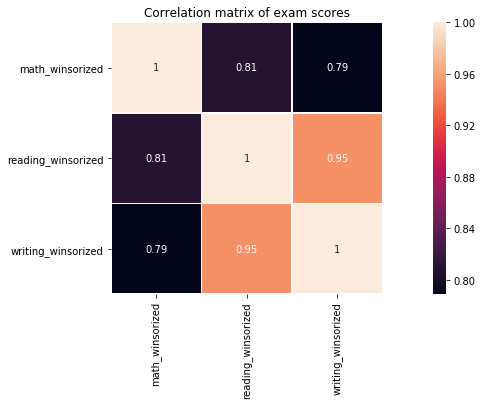

In [32]:
# Extract exam scores
exams = scores[scores.columns[-3:]]

# Make the correlation matrix
corr = exams.corr()

# Generate a heatmap from the matrix
plt.figure(figsize=(18, 5))

sns.heatmap(corr, square=True, annot=True, linewidths=0.5)
plt.title("Correlation matrix of exam scores")

plt.show()

From the correlation matrix above, it seems that reading and writing scores are most strongly correlated.